In [7]:
import sys
import os

# Add the path to the parent directory (where pyOVNA/ lives)
sys.path.insert(0, os.path.abspath('..'))

from pyOVNA.processing import read_ovna_file, plot_ovna_data
from pyOVNA.fitting import fit_propagation_length, fit_spectrum_peaks, fit_fano_resonance, fano_resonance_equation, calculate_q_numerically
from pyOVNA.filters import filter_data

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks


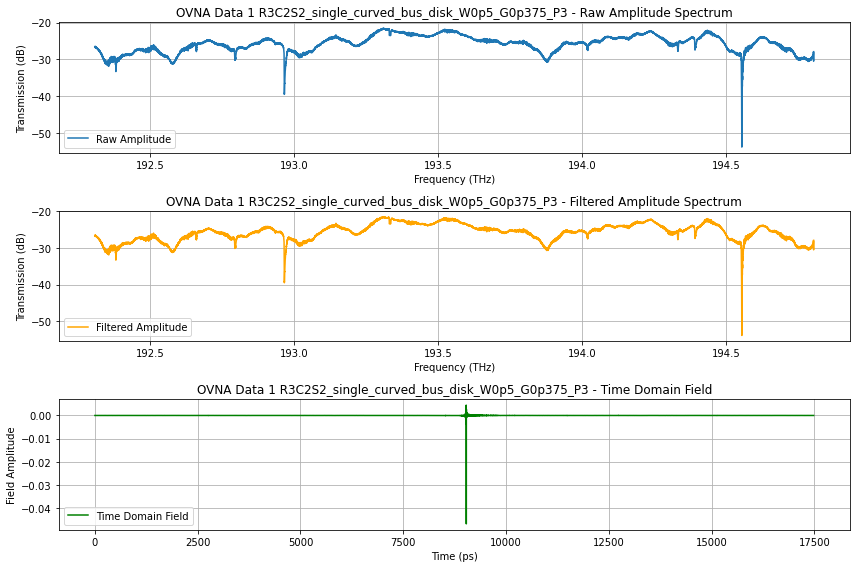

In [8]:
# Load the Transmission Measurements for 500nm waveguide
file_path = ['./data/R3C2S2_single_curved_bus_disk_W0p5_G0p375_P3.OVNA4',]

label_names = [os.path.splitext(os.path.basename(path))[0] for path in file_path]



# Process the file and extract data for each file
raw_data = read_ovna_file(file_path)

# Plot the raw data
plot_ovna_data(raw_data, label_names)



In [9]:
# Identify peaks in the amplitude magnitude data. Adjust height and prominence as needed.
# In this example, we are looking for peaks in the amplitude data
# Inverted signal in dB for peak detection
inverted_signal = -20*np.log10(np.abs(raw_data[0]['amplitude_filtered']))
peak_indices, peak_properties = find_peaks(inverted_signal, height=35, prominence=10)
peak_freqs = raw_data[0]['frequency'][peak_indices]

print("Peak frequencies:", peak_freqs)
print("Peak indices:", peak_indices)

# Select the peak of interest
index_peak = 1
# Select the span around the peak
peak_fit_range = 0.01 # THz

Peak frequencies: [192.96599751 194.55547313]
Peak indices: [ 4608 15734]


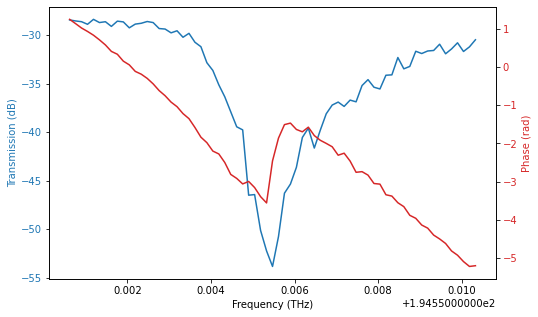

Resonance Frequency [THz]: 194.55547312771887
Extinction Ratio [dB]: 25.49


In [10]:
# Filter the data around the selected peak
# This will create a new frequency range and corresponding amplitude data
# The filter_data function will return the filtered frequencies and amplitudes
frequencies, amplitudes = filter_data(frequencies=raw_data[0]['frequency'], amplitudes=raw_data[0]['amplitude_filtered'] , min_frequency=peak_freqs[index_peak] - peak_fit_range/2 , max_frequency=peak_freqs[index_peak] + peak_fit_range/2 )

fig, ax1 = plt.subplots(figsize=(8, 5)
)
# Plot the magnitude (in dB) on the left y-axis
ax1.set_xlabel('Frequency (THz)')
ax1.set_ylabel('Transmission (dB)', color='tab:blue')
ax1.plot(frequencies, 20*np.log10(np.abs(amplitudes)), color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create a second y-axis for the phase
ax2 = ax1.twinx()
ax2.set_ylabel('Phase (rad)', color='tab:red')
ax2.plot(frequencies, np.unwrap(np.angle(amplitudes)), color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')
# ax2.set_ylim([-12.5, -5])
plt.show()

print('Resonance Frequency [THz]:', peak_freqs[index_peak])
print('Extinction Ratio [dB]: {:.2f}'.format(20 * np.log10(max(np.abs(amplitudes)) / min(np.abs(amplitudes)))))


In [11]:
# Fit the Fano resonance
popt, pcov = fit_fano_resonance(frequencies, abs(amplitudes))
fitted_fano = fano_resonance_equation(frequencies, *popt)

# # Print the fitted parameters
print("Fitted parameters:")
print("f0:", popt[0])
print("q:", popt[1])
print("gamma:", popt[2])

residuals = abs(amplitudes) - fano_resonance_equation(frequencies, *popt)
r_squared = 1 - np.var(residuals) / np.var(abs(amplitudes))
print("R-squared:", r_squared)

print('Q factor [from fitting]:', popt[0]/(popt[2]))
print('Q factor [numerical]:', calculate_q_numerically(frequencies, abs(amplitudes)))
print('Q factor Fitted [numerical]:', calculate_q_numerically(frequencies, fitted_fano))


Fitted parameters:
f0: 194.55493949750132
q: 3.1541276040071646
gamma: 0.0015918165406790781
R-squared: 0.981751027362682
Q factor [from fitting]: 122221.96121577117
Q factor [numerical]: 272369.60000366834
Q factor Fitted [numerical]: 170230.99999975268


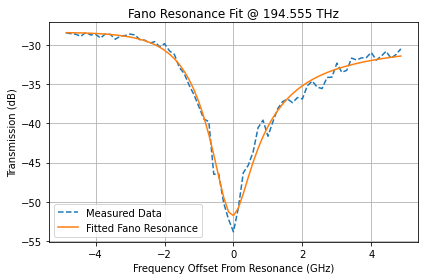

In [12]:
# Plot the original data and the fitted Fano resonance
plt.plot((frequencies-peak_freqs[index_peak])*1e3, 20*np.log10(abs(amplitudes)), label='Measured Data', linestyle='--')
plt.plot((frequencies-peak_freqs[index_peak])*1e3, 20*np.log10(fitted_fano), label='Fitted Fano Resonance')
plt.xlabel('Frequency Offset From Resonance (GHz)')
plt.ylabel('Transmission (dB)')
plt.title('Fano Resonance Fit @ {center:.3f} THz'.format(center=peak_freqs[index_peak]))
plt.legend()
plt.grid(visible=True,which='both')
plt.tight_layout()

